# 5. Unsupervised_Learning_Exploration

This notebook builds on the previously defined notebooks in the `TelescopeML/docs/tutorials` directory. Utilizing the same features and data preprocessing steps, we aim to apply multiple unsupervised learning methods to the synthetic Brown Dwarf dataset.

In [1]:
from Unsupervised_utils import *
from TelescopeML.DataMaster import *
from TelescopeML.DeepTrainer import *
from TelescopeML.Predictor import *
from TelescopeML.IO_utils import load_or_dump_trained_model_CNN
from TelescopeML.StatVisAnalyzer import *

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

## 5.1 Load the Synthetic spectra

We computed a low-resolution spectrum ($R$=200) utilizing atmopshric brown dwarfs grid model, [*Sonora-Bobcat*](https://arxiv.org/pdf/2107.07434.pdf) for spectral range $\sim$0.9-2.4 $\mu m$. An open-source atmospheric radiative transfer Python package, [*PICASO*](https://natashabatalha.github.io/picaso/) was employed for generating these datasets. This dataset encompass 30,888 synthetic spectra (or instances or rows). 

Each spectrum has 104 wavelengths (i.e., 0.897, 0.906, ..., 2.512 μm) and 4 output atmospheric parameters:

- gravity (log *g*)
- temperature (*T*<sub>eff</sub>)
- carbon-to-oxygen ratio (C/O)
- metallicity ([M/H])


In [2]:
import os 

__reference_data_path__ = os.getenv("TelescopeML_reference_data")
__reference_data_path__ 


# Note: insert the directory of the reference_data if you get an error reading the reference data!!!
# __reference_data_path__ = 'INSERT_DIRECTORY_OF_reference_data'


'/Users/sarah/Downloads/reference_data/'

### Load the dataset and check few instances

In [3]:
#Data read in, extract only wavelength data, unsupervised does not use labeled variables 
train_BD = pd.read_csv(os.path.join(__reference_data_path__, 
                                    'training_datasets', 
                                    'browndwarf_R100_v4_newWL_v3.csv.bz2'), compression='bz2')
train_BD.head()

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
3,5.0,1100,0.25,-0.3,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08
4,5.0,1100,0.25,0.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08


### 5.1.1 Check Atmosphere parameters
- gravity (log *g*)
- temperature (*T*<sub>eff</sub>)
- carbon-to-oxygen ratio (C/O)
- metallicity ([M/H])

In [4]:
output_names = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']

wavelength_names = [item for item in train_BD.columns.to_list() if item not in output_names]
wavelength_values = [float(item) for item in wavelength_names]
print(wavelength_names[:5])
print(wavelength_values[:10])

['2.512', '2.487', '2.462', '2.438', '2.413']
[2.512, 2.487, 2.462, 2.438, 2.413, 2.389, 2.366, 2.342, 2.319, 2.296]


In [5]:
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity'])

y = train_BD[output_names]


---

## 5.2 Processing the Data

Here we prepare the data for unsupervised learning tasks. We develop our own Data Processor to handle unsupervised standardization or normalization, where we only process the input data, excluding the labels. `Unsupervised_Data_Processor` is adjusted from the `Data_Processor` found in the `TelescopeML/DeepBuilder` module.

`Unsupervised_Data_Processor` processes the data in 1 of 2 ways:
- Normalization using MinMiaxScaler, transforming features to be in the range [0,1] via
$\begin{equation} \Large x_{scaled}=\frac{x-x_{min}}{x_{max}-x_{min}}\end{equation}$
- Standardization using StandardScaler normalizes data to have mean 0 via
$\begin{equation} \Large x_{scaled} = \frac{x-x_{mean}}{x_{std}}\end{equation}$

Both standardization techniques can be applied row or column wise.

In [6]:
data_processor = Unsupervised_Data_Processor( 
                             flux_values=X.to_numpy(),
                             wavelength_names=X.columns,
                             wavelength_values=wavelength_values,
                             output_values=y.to_numpy(),
                             output_names=output_names,
                             spectral_resolution=200,
                                )

In [7]:
# X = data_processor.standardize_X_row_wise(X=X)
# X = data_processor.standardize_X_column_wise(X=X)
X = data_processor.normalize_X_column_wise(X=X)
# X = data_processor.normalize_X_row_wise(X=X)

---

## 5.3 Define Unsupervised Learning Module


In [14]:
class Unsupervised_Algorithms():
    def __init__(self, X):
        self.X = X
    
    def kmeans(self, num_clusters, max_iter, f1, f2):
        km = KMeans(n_clusters=4, max_iter = 1000, n_init='auto')
        km.fit(self.X)
        y_kmeans = km.predict(self.X)
        fig, ax = plt.subplots(1,1)
        ax.scatter(self.X[:, f1], self.X[:, f2], c=y_kmeans, s=30, cmap='viridis')
        centers = km.cluster_centers_
        ax.scatter(centers[:, f1], centers[:, f2], c='black', s=200, alpha=0.5);
        ax.set_title(f'K-Means Clustering for features {f1} and {f2}')
        return fig
    
    def pca(self, num_components):
        pca = PCA(n_components=num_components)
        Xt = pca.fit_transform(self.X)
        fig, ax = plt.subplots(1,1)
        ax.scatter(Xt[:,0], Xt[:,1])
        ax.set_title('PCA')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        return fig
    
    def dbscan(self, eps, min_sample, f1, f2):
        data_2_features = self.X[:, [f1, f2]]

        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan_labels = dbscan.fit_predict(data_2_features)

        fig, ax = plt.subplots(1,1, figsize=(5, 4))

        unique_labels = set(dbscan_labels)
        for label in unique_labels:
            if label == -1:  # Noise points
                color = 'slategrey'  
                label_name = 'Noise'
                ax.scatter(data_2_features[dbscan_labels == label, 0], 
                            data_2_features[dbscan_labels == label, 1], 
                            c=color, label=label_name, s=15, alpha=0.01)
            else:  # Cluster points
                color = plt.cm.nipy_spectral(float(label) / len(unique_labels))
                label_name = f'Cluster {label}'
                plt.scatter(data_2_features[dbscan_labels == label, 0], 
                            data_2_features[dbscan_labels == label, 1], 
                            c=[color], label=label_name, s=50, alpha=1.0)  

        ax.set_title('DBSCAN Clustering with Two Features')
        plt.legend()
        ax.set_xlabel(f'Feature {f1}')
        ax.set_ylabel(f'Feature {f2}')
        return fig

In [15]:
method = Unsupervised_Algorithms(X)

### 5.3.1 K-Means Clustering

(30888, 104)


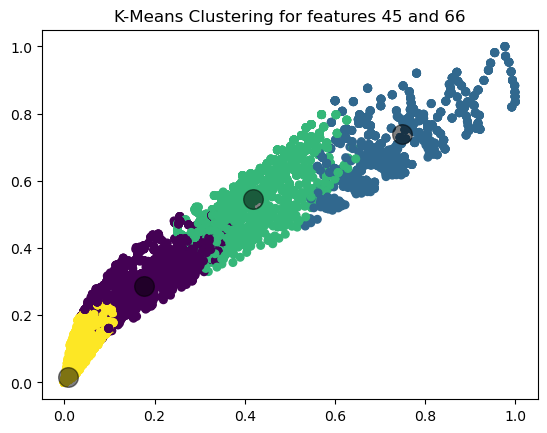

In [20]:
f = method.kmeans(num_clusters=4, max_iter = 1000, f1=45, f2=66);

### 5.3.2 Principal Component Analysis

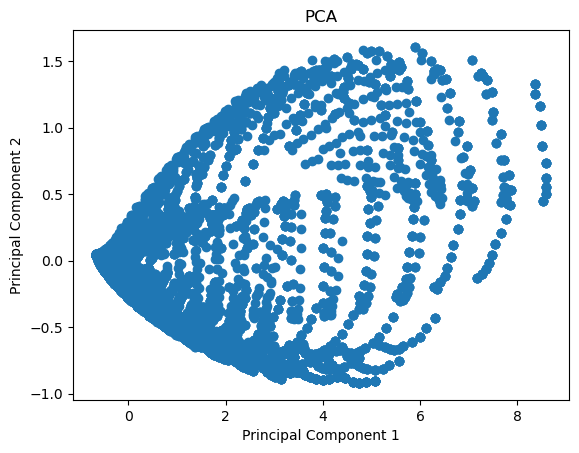

In [23]:
method.pca(num_components=3);

### 5.3.3 DBSCAN

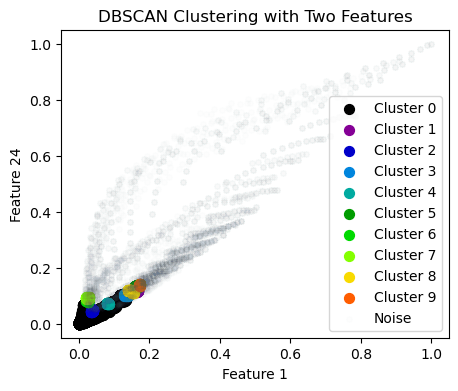

In [16]:
method.dbscan(0.005, 33, 1, 24);